In [1]:
import requests
import pandas as pd
from io import BytesIO,StringIO
import zipfile
import warnings
from datetime import datetime
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
import plotly.express as px
from fredapi import Fred

# this is for downloading stuff from website
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### 1. Data Preparation

#### 1.1 Define webscrape functions and desired series_id

In [2]:
def get_bls_txt(url):
    response = requests.get(url, headers = {"user-agent":"xinxianwang21@gmail.com"})
    data = StringIO(response.text)
    df = pd.read_csv(data, sep='\t')
    df.columns = df.columns.str.strip()
    return df

def get_bls_xls(url, sheet = 'Table 1', header = 2):
    response = requests.get(url, headers = {"user-agent":"xinxianwang21@gmail.com"})
    data = BytesIO(response.content)
    df = pd.read_excel(data, sheet_name=sheet, header = header)
    df.columns = df.columns.str.strip()
    return df

def get_bls_zip(zip_url, target_file_name, start_row):
    response = requests.get(zip_url, headers = {"user-agent":"xinxianwang21@gmail.com"})
    response.raise_for_status()  
    zip_file = zipfile.ZipFile(BytesIO(response.content))
    for file_name in zip_file.namelist():
        if file_name.endswith(target_file_name):
            with zip_file.open(file_name) as file:
               return pd.read_fwf(file, skiprows=start_row, header=None)
            
def order_df(df, list, mapping_df):
    '''Orders a pivot table based on series id list'''
    df = df[df['series_id'].isin(list)]
    df = df.pivot_table(values='value', columns = 'date', index='series_id').reindex(list)
    df = df.merge(mapping_df, on='series_id', how='left')
    df = df.set_index('series_title')
    df = df.drop('series_id',axis=1)
    return df

def expand_yearly_dec(df):
    '''Expands dec df to monthly df for RI calculation, need to convert index to year'''
    monthly_df = []
    for index, row in df.iterrows():
        monthly_index = pd.date_range(start=f'{index}-12-01', end=f'{index+1}-11-01', freq='MS')
        for month in monthly_index:
            new_row = {col: row[col] for col in df.columns}
            new_row['Date'] = month
            monthly_df.append(new_row)
    monthly_df = pd.DataFrame(monthly_df)
    monthly_df.set_index('Date', inplace=True)
    return monthly_df

In [3]:
sa_ids = [
    'CUSR0000SA0',  # All items
    'CUSR0000SAF1',  # Food
    'CUSR0000SAF11',  # Food at home
    'CUSR0000SEFV',  # Food away from home
    'CUSR0000SA0E',  # Energy
    'CUSR0000SA0L1E',  # All items less food and energy
    'CUSR0000SACL1E',  # Commodities less food and energy commodities
    'CUSR0000SAA',  # Apparel
    'CUSR0000SETA01',  # New vehicles
    'CUSR0000SETA02',  # Used cars and trucks
    'CUSR0000SAM1',  # Medical care commodities
    'CUSR0000SAF116', # Alcoholic Beverages
    'CUSR0000SEGA',  # Tobacco and smoking products
    'CUSR0000SASLE', # Services less Energy Services
    'CUSR0000SAH1',  # Shelter
    'CUSR0000SEHA',  # Rent of primary residence
    'CUSR0000SEHC',  # Owners' equivalent rent of residences
    'CUSR0000SAM2',  # Medical care services
    'CUSR0000SEMC01',  # Physicians' services
    'CUSR0000SEMD01',  # Hospital services
    'CUSR0000SAS4',  # Transportation services
    'CUSR0000SETD',  # Motor vehicle maintenance and repair
    'CUSR0000SETE',  # Motor vehicle insurance
    'CUSR0000SETG01'  # Airline fares
]

#### 1.2 Get SA MoM df

In [4]:
## get series id and value df
index_url = 'https://download.bls.gov/pub/time.series/cu/cu.data.0.Current'
df = get_bls_txt(index_url)
df['month'] = df['period'].str.extract(r'(\d{2})')[0]
df = df[(df['month'] != '13') & (df['year'] > 2012)].reset_index()
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'], format='%Y-%m')
df['series_id'] = df['series_id'].str.strip()
df = df[['date', 'series_id', 'value']]

## get series id and names mapping
name_url = 'https://download.bls.gov/pub/time.series/cu/cu.series'
name_df = get_bls_txt(name_url)
name_df = name_df[['series_id','series_title']]
name_df['series_id'] = name_df['series_id'].str.strip()

sa_df = order_df(df, sa_ids, name_df)
sa_df.index = sa_df.index.str.replace(" in U.S. city average, all urban consumers, seasonally adjusted", "", regex=False)
sa_df = sa_df.T
sa_df.index = pd.to_datetime(sa_df.index)
sa_df_mom = (sa_df.pct_change()*100).dropna()
sa_df_yoy = (sa_df.pct_change(12)*100).dropna()
sa_df = sa_df[sa_df.index>'2013-11']
sa_df_mom = sa_df_mom[pd.to_datetime(sa_df_mom.index)>'2013-11']
sa_df_yoy = sa_df_yoy[pd.to_datetime(sa_df_yoy.index)>'2013-12']

/var/folders/v5/0s6lmhmj5qbgv2qbqv79wyh80000gn/T/ipykernel_35127/3504371344.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data, sep='\t')


#### 1.3 Get updated RI and backout Core Services Ex Rent

In [5]:
# 2020 onwards RI are available here https://www.bls.gov/cpi/tables/relative-importance/home.htm#Weights
current_year = datetime.now().year - 1
ri_2020onward = None

for year in range(2020, current_year+1):
    url = f"https://www.bls.gov/cpi/tables/relative-importance/{year}.xlsx"
    df = get_bls_xls(url, header=4).dropna().drop(['Unnamed: 0', 'CPI-W'], axis=1)
    df = df.rename({'Unnamed: 1': 'series_title', 'CPI-U': f"{year}"}, axis=1)
    df = df.set_index('series_title').T
    df = df[sa_df_mom.columns]
    ri_df = df.loc[:,~df.columns.duplicated()].copy()
    ri_2020onward = pd.concat([ri_2020onward, ri_df], axis=0)

zip_url = "https://www.bls.gov/cpi/tables/relative-importance/ri-archive-2010-2019.zip"
ri_before2020 = None
for year in range(2013, 2020):
    # print(year)
    target_file_name = f"{year}.txt"
    df = get_bls_zip(zip_url, target_file_name, start_row=13)
    df.columns = ['series_title', str(year), 'CPI-W']
    df = df[['series_title', str(year)]]
    df['series_title'] = df['series_title'].str.replace('.', '', regex=False)
    if 'Airline fare' in df['series_title'].values:
        df['series_title'] = df['series_title'].str.replace('Airline fare', 'Airline fares', regex=False)
    df = df.set_index('series_title').T
    df = df[sa_df_mom.columns]
    df = df.loc[:,~df.columns.duplicated()].copy()
    ri_before2020 = pd.concat([ri_before2020, df], axis=0)
    
ri_all = pd.concat([ri_before2020, ri_2020onward], axis=0)

In [6]:
ri_all.index = ri_all.index.astype(int)
monthly_ri = expand_yearly_dec(ri_all)
sa_dec = sa_df[sa_df.index.month==12]
sa_dec.index = sa_dec.index.year.astype(int)
monthly_sa = expand_yearly_dec(sa_dec)

In [7]:
chg_since_dec = monthly_ri*(sa_df/monthly_sa)
updated_ri = chg_since_dec.div(chg_since_dec['All items'], axis=0)*100
updated_ri = updated_ri.dropna(how='all')
updated_ri['Core Services Ex Rent'] = (updated_ri['Services less energy services']-updated_ri['Rent of primary residence']-updated_ri['Owners\' equivalent rent of residences'])

In [8]:
updated_ri_mom = updated_ri.copy()
updated_ri_mom.index = updated_ri.index + pd.DateOffset(months=1)
sa_df_mom['Core Services Ex Rent'] = (sa_df_mom['Services less energy services']*updated_ri_mom['Services less energy services']
 -sa_df_mom['Rent of primary residence']*updated_ri_mom['Rent of primary residence']
 -sa_df_mom['Owners\' equivalent rent of residences']*updated_ri_mom['Owners\' equivalent rent of residences'])/updated_ri_mom['Core Services Ex Rent']

### 2. Generate Display Table, Charts

#### 2.1 SA table saved in sa_df_clean

In [9]:
sa_df_clean = sa_df_mom.iloc[-13:].sort_index(ascending=False)
sa_df_clean.index = pd.to_datetime(sa_df_clean.index).to_period('M')
sa_df_clean.loc['3m-MA'] = sa_df_clean.iloc[0:3].mean()
sa_df_clean.loc['6m-MA'] = sa_df_clean.iloc[0:6].mean()
new_order = ['3m-MA', '6m-MA'] + [row for row in sa_df_clean.index if row not in ['3m-MA', '6m-MA']]
sa_df_clean = sa_df_clean.loc[new_order]
columns_not_to_round = ['All items less food and energy','Core Services Ex Rent']

rounding_dict = {col: 1 for col in sa_df_clean.columns if col not in columns_not_to_round}
for col in columns_not_to_round:
    rounding_dict[col] = 2

sa_df_clean = sa_df_clean.round(rounding_dict)
sa_df_clean = sa_df_clean.astype(object).T ## need astype object to not mess up rounding
sa_df_clean

,3m-MA,6m-MA,2024-03,2024-02,2024-01,2023-12,2023-11,2023-10,2023-09,2023-08,2023-07,2023-06,2023-05,2023-04,2023-03
series_title,,,,,,,,,,,,,,,
All items,0.4,0.3,0.4,0.4,0.3,0.2,0.2,0.1,0.4,0.5,0.2,0.2,0.1,0.4,0.1
Food,0.2,0.2,0.1,0.0,0.4,0.2,0.2,0.3,0.2,0.2,0.2,0.2,0.2,0.0,0.1
Food at home,0.1,0.1,-0.0,-0.0,0.4,0.1,0.0,0.3,0.1,0.2,0.2,0.0,0.1,-0.2,-0.2
Food away from home,0.3,0.3,0.3,0.1,0.5,0.3,0.4,0.4,0.4,0.3,0.2,0.4,0.5,0.4,0.6
Energy,0.8,-0.2,1.1,2.3,-0.9,-0.2,-1.6,-2.1,1.2,4.4,-0.0,0.5,-3.0,0.7,-2.7
All items less food and energy,0.37,0.32,0.36,0.36,0.39,0.28,0.31,0.24,0.32,0.23,0.23,0.19,0.36,0.47,0.32
Commodities less food and energy commodities,-0.1,-0.1,-0.2,0.1,-0.3,-0.1,-0.2,-0.0,-0.2,-0.2,-0.3,-0.1,0.4,0.4,0.2
Apparel,0.2,-0.0,0.7,0.6,-0.7,-0.0,-0.6,0.0,-0.3,0.2,0.1,0.1,0.2,0.3,0.2
New vehicles,-0.1,-0.0,-0.2,-0.1,-0.0,0.2,-0.0,-0.1,0.2,0.2,-0.0,-0.0,-0.1,-0.1,0.3


#### 2.2 Contribution heatmap saved in heatmap

In [10]:
contri_all = sa_df_mom*updated_ri_mom/100
contri_all = contri_all.dropna(how='all').iloc[-13:].sort_index(ascending=False)
contri_all.index = pd.to_datetime(contri_all.index).to_period('M')
rounding_dict = {col: 2 for col in contri_all.columns}
contri_all = contri_all.round(rounding_dict)
contri_all_table = contri_all.T ## need astype object to not mess up rounding

In [11]:
contri_all_heat = contri_all.drop(['All items','Food'],axis=1)

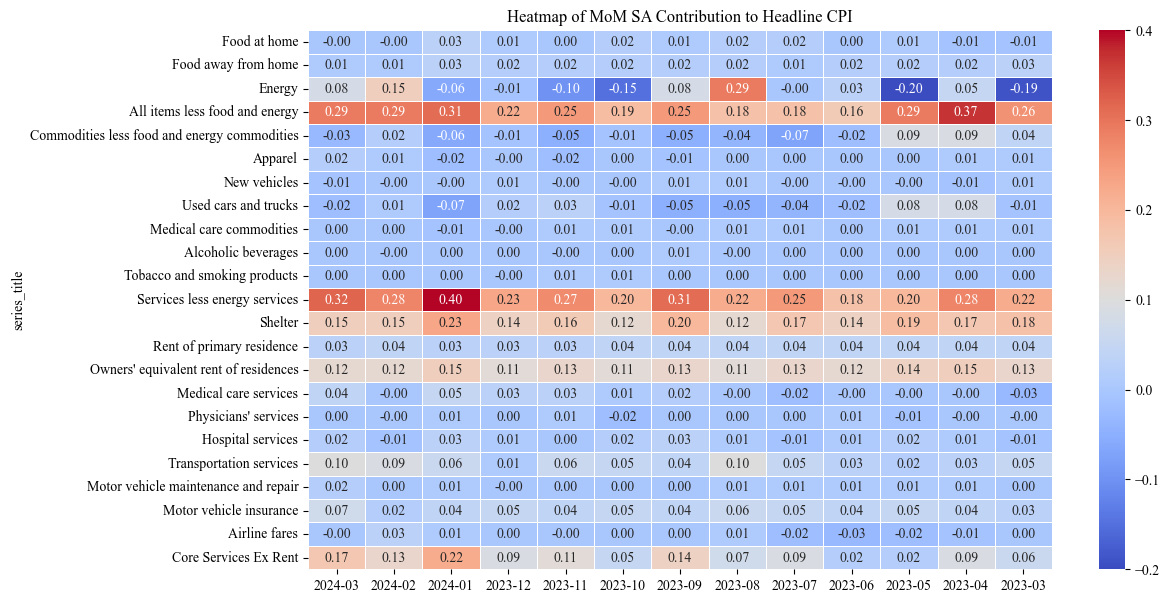

In [12]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(12, 7))
sns.heatmap(contri_all_heat.T, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Heatmap of MoM SA Contribution to Headline CPI")
heamap = plt
heamap.show()

#### 2.3 Rent plot saved in fig_rent

In [13]:
zillow_link = 'https://files.zillowstatic.com/research/public_csvs/zori/Metro_zori_uc_sfrcondomfr_sm_sa_month.csv?t=1715547239'
current_date = datetime.now()
year = current_date.year
month = current_date.month - 1
if month == 0:
    year -= 1
    month = 12
month_str = f"{month:02d}"
base_url = "https://assets.ctfassets.net/jeox55pd4d8n/4bPuuqiIFhucmvQm1ypFch/df9b14296863e440d27ba77d29c9b7e9/Apartment_List_Rent_Estimates_"
apartment_list = f"{base_url}{year}_{month_str}.csv"

In [14]:
AL_rent = pd.read_csv(apartment_list)
AL_rent = AL_rent[(AL_rent['location_name']=='United States') & (AL_rent['bed_size']=='overall')]
AL_rent = AL_rent.drop(['location_type','location_fips_code','population','state','county','metro','bed_size'],axis=1)
AL_rent = AL_rent.drop('location_name',axis=1)
AL_rent = AL_rent.melt(var_name='Date', value_name='ApartmentList Rent Index')
AL_rent['Date'] = pd.to_datetime(AL_rent['Date'], format='%Y_%m')+ pd.offsets.MonthBegin(0)
AL_rent.set_index('Date', inplace=True)

In [15]:
zillow = pd.read_csv(zillow_link)
zillow = zillow[(zillow['RegionName']=='United States')]
zillow = zillow.drop(['RegionID','SizeRank','RegionType','StateName'],axis=1)
zillow = zillow.drop(['RegionName'],axis=1)
zillow = zillow.melt(var_name='Date', value_name='Zillow Rent Index')
zillow['Date'] = pd.to_datetime(zillow['Date'], format='%Y-%m-%d')+ pd.offsets.MonthBegin(0)
zillow.set_index('Date', inplace=True)
alt_rent = AL_rent.join(zillow,how='left')
alt_rent_yoy = alt_rent.pct_change(12)*100
alt_rent_yoy = alt_rent_yoy.dropna()
alt_rent_yoy['CPI: OER'] = sa_df_yoy['Owners\' equivalent rent of residences']
# alt_rent_yoy['CPI: Rent of Primary Residence'] = sa_df_yoy['Rent of primary residence']
alt_rent_yoy = alt_rent_yoy.round(2)

In [16]:
def annualized_rate(changes):
    return ((1 + changes/100).prod() ** (12 / len(changes)) - 1) * 100
for col in ["Owners' equivalent rent of residences"]:
    alt_rent_yoy[f'3m-annualized OER'] = sa_df_mom[col].rolling(3).apply(annualized_rate)
    alt_rent_yoy[f'6m-annualized OER'] = sa_df_mom[col].rolling(6).apply(annualized_rate)

In [17]:
fig_rent = go.Figure()
for col in alt_rent_yoy.columns:
    fig_rent.add_trace(go.Scatter(
        x=alt_rent_yoy.index,
        y=alt_rent_yoy[col],
        name=col
    ))

fig_rent.update_layout(
    title='Rent Inflation Measures',
    xaxis_title='Date',
    yaxis_title='Percent Change, year ago',
    font=dict(
    family="Times New Roman", 
    size=14,                   
    color="black"             
)
)
fig_rent.show()

#### 2.4 Contribution to Core saved in fig_core_contr

In [18]:
contri_to_core = sa_df_mom*updated_ri_mom.div(updated_ri_mom['All items less food and energy'],axis=0)
contri_to_core.drop(['All items','Food','Food at home','Food away from home','Energy'],axis=1, inplace=True)
contri_to_core = contri_to_core.round(2).dropna(how='all')

In [19]:
fig_core_contr = go.Figure()
for col in ['Commodities less food and energy commodities', 'Rent of primary residence',
       'Owners\' equivalent rent of residences', 'Medical care services', 'Transportation services']:
    fig_core_contr.add_trace(go.Bar(
        x=contri_to_core.index,
        y=contri_to_core[col],
        name=col
    ))

fig_core_contr.add_trace(go.Scatter(        
    x=contri_to_core.index,
    y=contri_to_core['All items less food and energy'],
    name='All items less food and energy',
    mode='lines',
    line=dict(color='rgb(0, 70, 140)')
))


fig_core_contr.update_layout(
    barmode='relative',
    title='MoM Contribution to Core',
    xaxis_title='Date',
    yaxis_title='Contribution Value',
    font=dict(
    family="Times New Roman", 
    size=14,                   
    color="black"             
)
)

fig_core_contr.show()

#### 2.5 PCE and CPI analysis saved in time_series_fig and dist_plot_fig

In [20]:
fred = Fred(api_key="d0b19bd01f39fdd7318477768791c1a9")
df = pd.DataFrame({series: fred.get_series(series) for series in ['PCEPILFE']})
df = df.pct_change(12,fill_method=None) * 100 
df.columns = ['Core_PCE_yoy']
df['Core_CPI_yoy'] = sa_df_yoy['All items less food and energy']
df['PCE, CPI Wedge (Core)'] = df['Core_PCE_yoy'] - df['Core_CPI_yoy']
df = df[df.index.year>2013]

time_series_fig = go.Figure()
time_series_fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Core_PCE_yoy'],
    name='Core_PCE_yoy',
    mode='lines',
    line=dict(color='red')
))
time_series_fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Core_CPI_yoy'],
    name='Core_CPI_yoy',
    mode='lines',
    line=dict(color='blue')
))

time_series_fig.update_layout(
    title='Core PCE vs CPI',
    xaxis_title='Date',
    yaxis_title='Percent Change, year ago',
    font=dict(
    family="Times New Roman", 
    size=14,                   
    color="black"             
)
)
time_series_fig.show()

In [21]:
dist_plot_fig = px.histogram(df, x='PCE, CPI Wedge (Core)', nbins=30, title='Distribution of Core PCE-CPI Wedge (10y history)')
dist_plot_fig.update_layout(
    font=dict(family='Times New Roman'),
    width = 600,
    height = 400
)